# Introdução à Convolução

A convolução é uma média móvel ponderada.
Este notebook é para experimentar uma convolução bidimensional.

Na figura abaixo, o kernel (em amarelo) está somando os pixels das
diagonais. O kernel é (3x3). A imagem resultante, em rosa, 
é 2 colunas e 2 linhas menores que a imagem de entrada (verde).

![](http://mourafiq.com/images/posts/convolution_schematic.gif)

In [ ]:
import torch
import torch.nn.functional as F

In [ ]:
def conv2d(x, w, padding=0):
    assert x.ndimension() == 2, f'x must have 2 dimensions: {x.shape}'
    assert w.ndimension() == 2, f'w must have 2 dimensions: {w.shape}'
    # Faz a convolução colocando 4 dimensões
    x4d = x.unsqueeze(0).unsqueeze(0)
    w3d = w.unsqueeze(0).unsqueeze(0)
    y = F.conv2d(x4d, w3d, padding=padding, bias=None)
    return y.squeeze(0).squeeze(0)

In [ ]:
f = torch.arange(24,dtype=torch.float).reshape(4,6)
f


tensor([[ 0.,  1.,  2.,  3.,  4.,  5.],
        [ 6.,  7.,  8.,  9., 10., 11.],
        [12., 13., 14., 15., 16., 17.],
        [18., 19., 20., 21., 22., 23.]])

In [ ]:
f1 = torch.FloatTensor([[1., 0., -1]])
f1

tensor([[ 1.,  0., -1.]])

In [ ]:
conv2d(f,f1)

tensor([[-2., -2., -2., -2.],
        [-2., -2., -2., -2.],
        [-2., -2., -2., -2.],
        [-2., -2., -2., -2.]])

In [ ]:
fi = torch.zeros((4,6))
fi[1,2]=1.
fi

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])

### Propriedade da Resposta ao Impulso: o kernel é revelado
Nota-se que na implementação do Pytorch, o kernel aparece 
refletido. Isto porque na realidade a implementação é de
uma correlação e não convolução. Mas isto não tem nenhum
impacto, pois os pesos serão treinados e tanto faz se o
kernel será treinado refletido ou não. É importante entretanto
quando se for fazer uma cópia de pesos de um ambiente para
outro.

In [ ]:
conv2d(fi,f1,padding=[0,1])

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.]])

### Convolução é comutativa: conv(a,b) == conv(b,a)




In [ ]:
conv2d(fi,f)

tensor([[8.]])

In [ ]:
conv2d(f,fi)

tensor([[8.]])

### Reproduzindo o exemplo da figura animada

In [ ]:
x = torch.FloatTensor([
              [1,1,1,0,0],
              [0,1,1,1,0],
              [0,0,1,1,1],
              [0,0,1,1,0],
              [0,1,1,0,0]])
W = torch.FloatTensor([
              [1,0,1],
              [0,1,0],
              [1,0,1]])
conv2d(x,W)


tensor([[4., 3., 4.],
        [2., 4., 3.],
        [2., 3., 4.]])

## Reproduzindo exemplo com pad = 1

Interprete os resultados utilizando pad 1

In [ ]:
conv2d(x,W,padding=1)

tensor([[2., 2., 3., 1., 1.],
        [1., 4., 3., 4., 1.],
        [1., 2., 4., 3., 3.],
        [1., 2., 3., 4., 1.],
        [0., 2., 2., 1., 1.]])

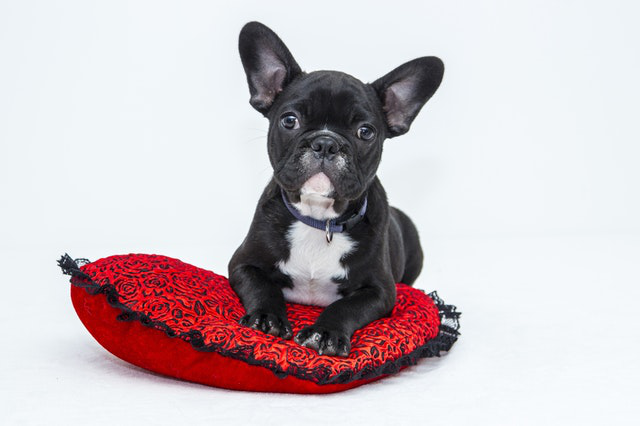

In [ ]:
from torchvision import transforms
img2tensor = transforms.ToTensor()
from PIL import Image
import requests
from io import BytesIO

url = "https://raw.githubusercontent.com/robertoalotufo/files/master/data/dog1.jpg"
response = requests.get(url)
img_PIL = Image.open(BytesIO(response.content))
img_PIL

In [ ]:
img_pt = img2tensor(img_PIL)
img_pt.shape, img_pt.dtype, img_pt.min(), img_pt.max()

(torch.Size([3, 426, 640]), torch.float32, tensor(0.), tensor(1.))

### Convertendo para níveis de cinza (2D)

In [ ]:
img2d_pt = img_pt.mean(0)
img2d_pt.shape

torch.Size([426, 640])

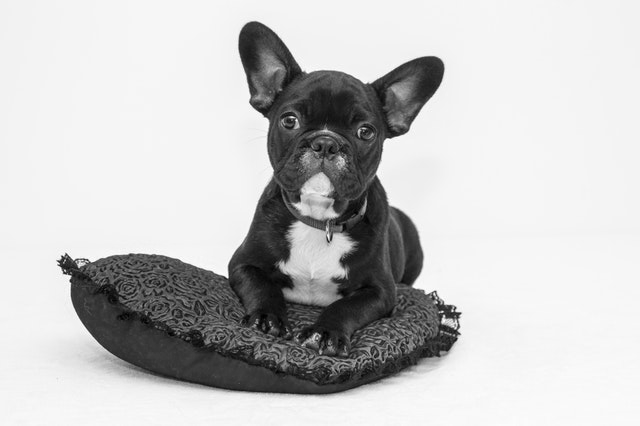

In [ ]:
transforms.ToPILImage()(img2d_pt)

In [ ]:
W = torch.FloatTensor([[ 0, -1, -1],
                       [-1, 0, -1],
                       [ -1,-1, 0]])

In [ ]:
y = conv2d(img2d_pt,W)
y.shape

torch.Size([424, 638])

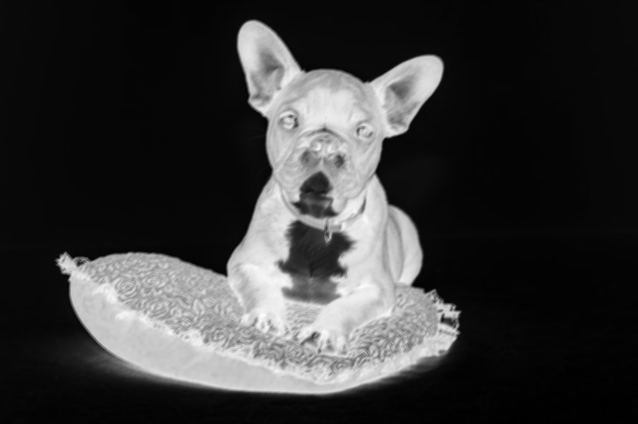

In [ ]:
y -= y.min()
y /= y.max()
transforms.ToPILImage()(y)

# Exercício

Programar a convolução 2 D de forma explícita, e trocar a função conv2d pela
myconv2d abaixo e conseguir rodar todas os exemplos deste notebook.

In [ ]:
import numpy as np
def add_padding(input_matrix, padding):
    if type(padding).__name__ == "int":
      padding = [padding, padding]

    # recuperar dimensões de entrada 
    row_input_size, colum_input_size = input_matrix.shape
    row_pad, column_pad = padding
    
    padded_matrix = np.zeros((row_input_size + row_pad * 2, colum_input_size + column_pad * 2)) # Multiplica por 2, devido que o padding deve ser aplicado na largura da matriz como no comprimento.
    padded_matrix[row_pad : row_input_size + row_pad, column_pad : colum_input_size + column_pad] = input_matrix # preenche a matriz com os valores reais (não padding)

    return padded_matrix


def myconv2d(x, w, padding=0, strides=0):

    # implementar
    assert x.ndimension() == 2, f'x must have 2 dimensions: {x.shape}'
    assert w.ndimension() == 2, f'w must have 2 dimensions: {w.shape}'

    x = x.numpy() 
    w = w.numpy()

    if padding != 0:
      x = add_padding(x, padding)

    # recupero as dimensões tanto da imagem x quanto do filtro/kernel w
    w_height, w_width = w.shape
    x_height, x_width = x.shape
   
    # Obtendo a diferença entre a dimensão da entrada em relação ao filtro, isso irá definir quantas vezes a convolução vai ocorrer na horizontal e vertical.
    #Ao final retornando a matriz de convolução.
    out_height = x_height - w_height + 1
    out_width = x_width - w_width + 1
    
    result_conv = np.zeros((out_height, out_width)).astype(np.float32)

    for y_matrix in range(0, out_height):
      for x_matrix in range(0, out_width):
        result_conv[y_matrix][x_matrix] = np.sum(x[y_matrix :y_matrix + w_height, x_matrix :x_matrix + w_width] * w).astype(np.float32)
    return  torch.Tensor(result_conv)

### Reproduzindo testes

In [ ]:
import numpy as np
f = torch.arange(24,dtype=torch.float).reshape(4,6)
f1 = torch.FloatTensor([[1., 0., -1]])

print(myconv2d(f,f1))
print("As matrizes resultantes são iguais?", torch.equal(conv2d(f,f1), myconv2d(f,f1)))

tensor([[-2., -2., -2., -2.],
        [-2., -2., -2., -2.],
        [-2., -2., -2., -2.],
        [-2., -2., -2., -2.]])
As matrizes resultantes são iguais? True


In [ ]:
fi = torch.zeros((4,6))
fi[1,2]=1.
print(myconv2d(fi,f1,padding=[0,1]))
print("As matrizes resultantes são iguais?", torch.equal(conv2d(fi,f1,padding=[0,1]), myconv2d(fi,f1,padding=[0,1])))

#Convolução é comutativa: conv(a,b) == conv(b,a)
print('Convolução é comutativa: conv(a,b) == conv(b,a)')
print(myconv2d(fi,f))
print(myconv2d(f,fi))



tensor([[ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.]])
As matrizes resultantes são iguais? True
Convolução é comutativa: conv(a,b) == conv(b,a)
tensor([[8.]])
tensor([[8.]])


In [ ]:
# Reproduindo o exemplo da figura animada
print('Reproduindo o exemplo da figura animada')
x = torch.FloatTensor([
              [1,1,1,0,0],
              [0,1,1,1,0],
              [0,0,1,1,1],
              [0,0,1,1,0],
              [0,1,1,0,0]])
W = torch.FloatTensor([
              [1,0,1],
              [0,1,0],
              [1,0,1]])
print(myconv2d(x,W))
print("As matrizes resultantes são iguais?", torch.equal(conv2d(x,W), myconv2d(x,W)))

Reproduindo o exemplo da figura animada
tensor([[4., 3., 4.],
        [2., 4., 3.],
        [2., 3., 4.]])
As matrizes resultantes são iguais? True


In [ ]:
#testando com padding
print('Testando com Padding')
print(myconv2d(x,W,padding=1))


print("As matrizes resultantes são iguais?", torch.equal(conv2d(x,W,padding=1),  myconv2d(x,W,padding=1)))

Testando com Padding
tensor([[2., 2., 3., 1., 1.],
        [1., 4., 3., 4., 1.],
        [1., 2., 4., 3., 3.],
        [1., 2., 3., 4., 1.],
        [0., 2., 2., 1., 1.]])
As matrizes resultantes são iguais? True


### Testando com a imagem real

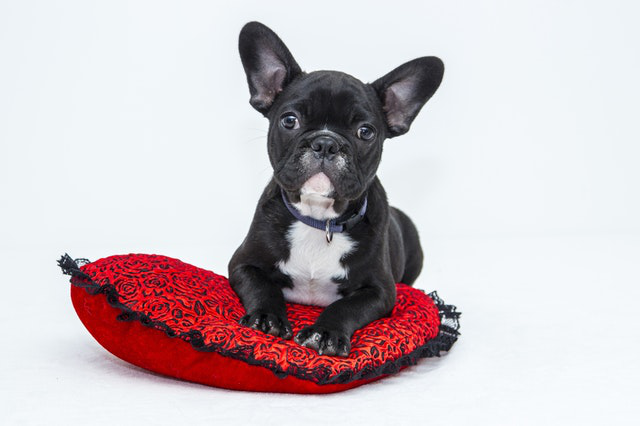

In [ ]:
url = "https://raw.githubusercontent.com/robertoalotufo/files/master/data/dog1.jpg"
response = requests.get(url)
img_PIL = Image.open(BytesIO(response.content))
img_PIL

In [ ]:
img_pt = img2tensor(img_PIL)
img_pt.shape, img_pt.dtype, img_pt.min(), img_pt.max()

(torch.Size([3, 426, 640]), torch.float32, tensor(0.), tensor(1.))

torch.Size([426, 640])


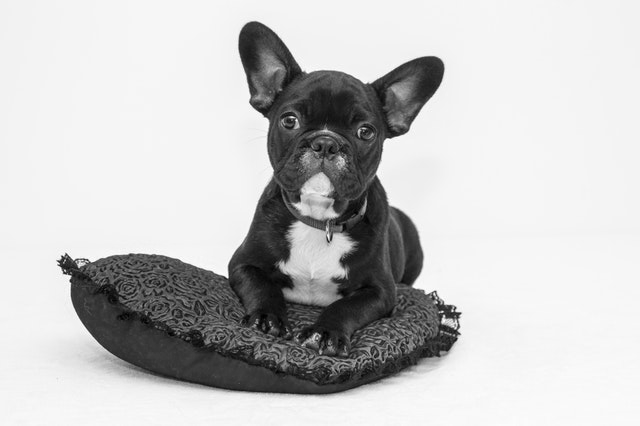

In [ ]:
# convertendo em tons de cinza
img2d_pt = img_pt.mean(0)
print(img2d_pt.shape)
transforms.ToPILImage()(img2d_pt)


In [ ]:
W = torch.FloatTensor([[ 0, -1, -1],
                       [-1, -1, -1],
                       [ -1,-1, 0]])

In [ ]:
y = myconv2d(img2d_pt,W)
print(y.shape)



torch.Size([424, 638])


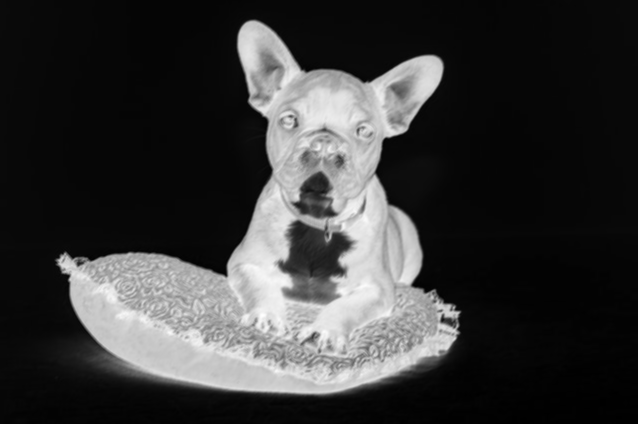

In [ ]:
y -= y.min()
y /= y.max()
transforms.ToPILImage()(y)